In [1]:
import pandas as pd
from functools import reduce

lions = pd.read_html(r"List of Detroit Lions seasons - Wikipedia.html")[1].T.droplevel(0).T
lions["Season"].replace("\[.*\]", "", regex=True, inplace=True)
lions = lions[lions["Season"].str.isnumeric()]
lions = lions[["Season", "W", "L", "T", "Finish"]]
lions["Finish"].replace(regex={"T–":"", "(st|nd|rd|th)(\[.*\])?":""}, inplace=True)
lions = lions.apply(pd.to_numeric)
lions["Win%"] = lions["W"] / (lions[["W", "L", "T"]].sum(axis=1))
lions.loc[lions["Finish"] > 4, "Finish"] = 4
lions = lions[["Season", "Win%", "Finish"]]

tigers = pd.read_html(r"List of Detroit Tigers seasons - Wikipedia.html")[3]
tigers["Finish"].replace(regex={"T–":"", "(st|nd|rd|th)(\[.*\]| ¤)?":""}, inplace=True)
tigers = tigers[["Season", "Win%", "Finish"]].apply(pd.to_numeric)
tigers = tigers.apply(pd.to_numeric)
tigers.drop(80, inplace=True) # drop first half of split season of 1981
tigers.reset_index(drop=True, inplace=True)
tigers.loc[tigers["Finish"] > 4, "Finish"] = 4

red_wings = pd.read_html(r"List of Detroit Red Wings seasons - Wikipedia.html")[2]
red_wings = red_wings.drop("Postseason", axis=1, level=0).T.droplevel(0).T
red_wings["Franchise season"] = red_wings["Franchise season"].apply(lambda x: x.split("–")[0])
red_wings = red_wings[["Franchise season", "W", "L", "T", "Finish"]]
red_wings.rename({"Franchise season": "Season"}, axis=1, inplace=True)
red_wings = red_wings[red_wings["Season"].str.isnumeric()]
red_wings.replace("—(?:\[.*\])?", "", regex=True, inplace=True)
red_wings["Finish"].replace(regex={"(st|nd|rd|th)":""}, inplace=True)
red_wings = red_wings.apply(pd.to_numeric)
red_wings["Season"] = red_wings["Season"] + 1
red_wings["Win%"] = red_wings["W"] / (red_wings[["W", "L", "T"]].sum(axis=1))
red_wings.loc[red_wings["Finish"] > 4, "Finish"] = 4
red_wings = red_wings[["Season", "Win%", "Finish"]]

pistons = pd.read_html("List of Detroit Pistons seasons - Wikipedia.html")[1]
pistons["Team"] = pistons["Team"].apply(lambda x: x.split("–")[0])
pistons.rename({"Team": "Season"}, axis=1, inplace=True)
pistons = pistons[pistons["Season"].str.isnumeric()]
pistons.loc[pistons["Finish"].isna(), "Finish"] = pistons["Finish.1"]
pistons["Finish"].replace(regex={"(st|nd|rd|th)":""}, inplace=True)
pistons = pistons[["Season", "Win%", "Finish"]].apply(pd.to_numeric)
pistons["Season"] = pistons["Season"] + 1
pistons.loc[pistons["Finish"] > 4, "Finish"] = 4

df_dict = {
    "NFL\nLions": lions,
    "MLB\nTigers": tigers,
    "NHL\nRed Wings": red_wings,
    "NBA\nPistons": pistons
}
    
df_finish = reduce(lambda left,right: pd.merge(left,right,on='Season'), df_dict.values())
df_finish = df_finish[["Season", "Finish_x", "Finish_y"]].set_index("Season")
df_finish.replace(4, pd.np.nan, inplace=True)
df_summary = df_finish.apply(pd.value_counts, axis=1).replace(pd.np.nan, 0)

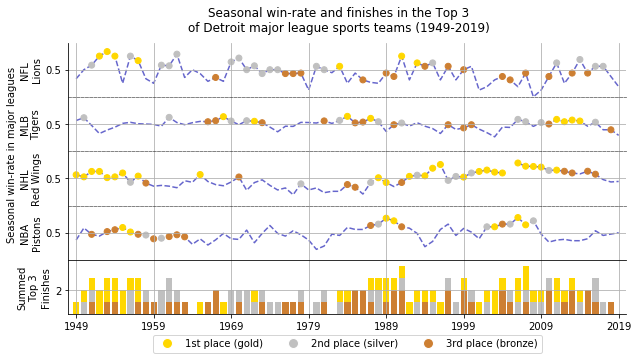

In [18]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.lines import Line2D

cmap = mcolors.ListedColormap(("gold", "silver", "#cd7f32"))
norm = mcolors.BoundaryNorm([1, 2, 3, 4], cmap.N)
colormap = cm.ScalarMappable(norm=norm, cmap=cmap)
colormap.set_array([])

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10,5))
plt.suptitle("Seasonal win-rate and finishes in the Top 3\nof Detroit major league sports teams (1949-2019)")

for index, team in enumerate(df_dict.keys()):
    aligned_team = df_dict[team][df_dict[team]["Season"].ge(1949) & df_dict[team]["Season"].lt(2020)]
    axs[index].plot(aligned_team["Season"], aligned_team["Win%"], '--', c=(.4,.4,.8), zorder=0)
    relevant_scatter = aligned_team[aligned_team["Finish"] < 4]
    axs[index].scatter(relevant_scatter["Season"], relevant_scatter["Win%"], c=relevant_scatter["Finish"], cmap=cmap, clip_on=False, zorder=1)
    axs[index].grid(True)
    axs[index].set_ylabel(team)
    axs[index].set_ylim((0,1))
    axs[index].set_yticks([0.5])
    axs[index].spines["right"].set_visible(False)
    axs[index].spines["top"].set_linestyle('--')
    axs[index].spines["top"].set_alpha(0.6)
    axs[index].spines["bottom"].set_visible(False)

axs[0].spines["top"].set_visible(False)

axs[4].bar(df_summary.index, df_summary[3.0], color="#cd7f32")
axs[4].bar(df_summary.index, df_summary[2.0], bottom=df_summary[3.0], color="silver")
axs[4].bar(df_summary.index, df_summary[1.0], bottom=df_summary[2.0] + df_summary[3.0], color="gold")
axs[4].set_ylim((0,4.5))
axs[4].set_yticks([2])
axs[4].spines["right"].set_visible(False)
axs[4].grid(True)
axs[4].set_ylabel("Summed\nTop 3\nFinishes")

plt.gca().set_xticks(range(1949, 2020, 10))
plt.gca().set_xlim((1948,2020))
plt.subplots_adjust(hspace=0)
fig.text(0.04, 0.57, 'Seasonal win-rate in major leagues', va='center', rotation='vertical')

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor="gold", markersize=10, label="1st place (gold)"),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor="silver", markersize=10, label="2nd place (silver)"),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor="#cd7f32", markersize=10, label="3rd place (bronze)")]
plt.legend(handles=legend_elements, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.8))
plt.savefig("Assignment4.png", dpi=300)